In [1]:
from cvxpy import *
import numpy as np
import networkx as nx
import scipy.linalg as sla
import mosek
import matplotlib.pyplot as plt
%precision %.2f
np.set_printoptions(precision=2)

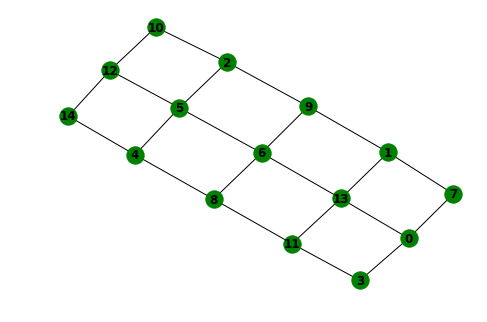

In [132]:
# networks Set up 
# Create Graph Object
G = nx.grid_graph([3,5])
e = G.number_of_edges();
v = G.number_of_nodes();


# --------Source Vector set up ----------------#
sourceNode = 14; 
sinkNode = 7;
sourceVec = np.zeros((v));
sourceVec[sourceNode] = -1;
sourceVec[sinkNode] = 1;

#---------Draw Graph---------#
G = nx.convert_node_labels_to_integers(G)
nx.draw(G, node_color='g', edge_color='k', with_labels=True, font_weight='bold')
edgeList = list(G.edges);


In [24]:
# ActionNum = 5;
# #------------latency function-------------------#
# # Currently only state dependent
# def Reward(x): 
#     A = np.diag(np.linspace(1,v,v))
#     b = np.linspace(v-1,0, v) 
#     RewardMat= np.array([A.dot(x) + b,]*ActionNum).T
#     return RewardMat;
# #-------------probability transition parameters----------------------#
# oneV = np.ones((v))
# def Pmat(action):
#     return (1. - action)/v* np.outer(oneV, oneV) + (action - (1. - action)/v)*np.diag(oneV);
# Pmat(3)


True

In [133]:
# Generate routes matrix
def RouteGen(graph, edgeSet, sourceN, sinkN):
    routes =  list(nx.all_simple_paths(graph, source=sourceN, target=sinkN));
    RouteMat = np.zeros((graph.number_of_edges(), len(routes)));
    for route in range(0,len(routes)):
        curRoute = routes[route];#Route is in nodes
        #Look for the index of corresponding edge
        for edge in range(0,len(curRoute)-1):
            #Unpack edge
            start= curRoute[edge]; end = curRoute[edge+1];
            edgeInd = 0;
            #find the edge index in list
            try:
                edgeInd = edgeSet.index((end,start));    
            except ValueError:
                edgeInd = edgeSet.index((start,end)); 
                
#             print(edgeInd)
            RouteMat[edgeInd,route]= 1;
    return RouteMat;
RouteMat = RouteGen(G,edgeList,sourceNode,sinkNode)
e,r = RouteMat.shape
#---------Construct the latency functions-----------
scale = 5;
A = np.diag(scale * np.random.random_sample((e)));
b = scale * np.random.random_sample((e));

In [142]:
# Construct the problem.
#----------------WARDROP EQUILIBRIUM--------------------
mass = 10.0;
x = Variable(e); 
z = Variable(r);
warPot =  b*x + quad_form(x,A)*0.5;
warObj = Minimize(warPot);
warConstraints = [0 <= z, 
                  RouteMat*z == x,
                  sum(z) == mass]
wardrop = Problem(warObj, warConstraints)
warRes = wardrop.solve(solver=MOSEK)
print(warRes)

378.431118593


In [159]:
# make flow the colours
flow = x.value.A1
# create weight dictionary
edgeDictionary = {}
for edge in range(0,len(edgeList)):
    edgeDictionary[edgeList[edge]] = round(flow[edge]/mass,2)

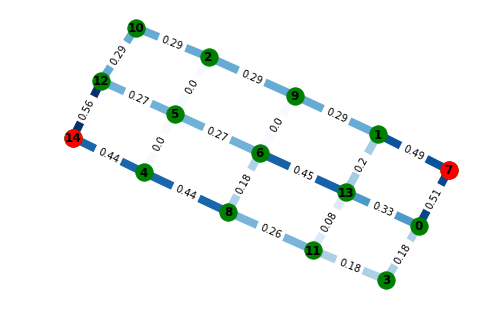

In [161]:
# Equilibrium flow of graph
pos=nx.spring_layout(G);
nx.draw(G, pos=pos, node_color='g', edge_cmap=plt.cm.Blues, width=8,edge_color=(flow), with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeDictionary);
nx.draw_networkx_nodes(G,pos, nodelist = {sourceNode,sinkNode},nodeColor='r')

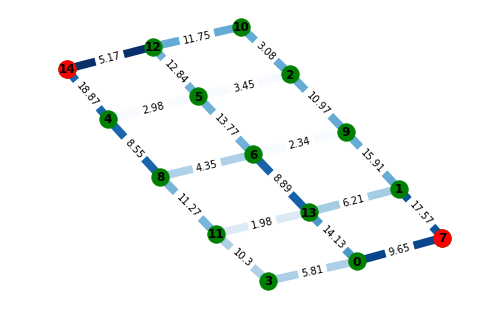

In [162]:
# Equilibrium costs of graph
# make flow the colours
cost = A.dot(x.value).A1 + b;
# create weight dictionary
costDictionary = {}
for edge in range(0,len(edgeList)):
    costDictionary[edgeList[edge]] = round(cost[edge],2)
    
pos=nx.spring_layout(G);
nx.draw(G, pos=pos, node_color='g', edge_cmap=plt.cm.Blues, width=8,edge_color=flow, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G,pos,edge_labels=costDictionary);
nx.draw_networkx_nodes(G,pos, nodelist = {sourceNode,sinkNode},nodeColor='r')

In [58]:
# # Compare social potential of graph with/without the edge
# socialFull = returnPotValues(50, 0.1, Q, wheat, edges, sourceNode, sinkNode, A,b);  
# socialNoEdge = returnPotValues(50, 0.1, Q, wheatRemoved, edges2, sourceNode, sinkNode, ARemoved,bRemoved); 

# plt.figure()
# plt.plot(socialFull[0,:],socialFull[1,:] ,label=("Social Potential At Wardrop"));
# plt.plot(socialFull[0,:],socialNoEdge[1,:],label=("Social Potential After removing the edge"));

# plt.xlabel('Mass Input')
# plt.ylabel('Potential Value')
# plt.title('Potential Comparison:')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)